In [ ]:
import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # For formatting x-axis with years
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression



In [ ]:
def load_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, auto_adjust=False)

    if data.empty:
        print(f"Error: No data retrieved for {ticker}. Check API availability.")
        sys.exit(1)  # Stop the script if data is missing

    data.reset_index(inplace=True)
    return data
def create_sequences(X, y, dates, time_steps):
    X_seq, y_seq, date_seq = [], [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
        date_seq.append(dates[i + time_steps])  # Store corresponding date
    return np.array(X_seq), np.array(y_seq), np.array(date_seq)


In [ ]:
main_ticker = "^GSPC"
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TSLA", "^IRX", "^VIX", "^TNX"]
TRAIN_START = "2015-01-01"
TRAIN_END = "2025-02-01"
data = load_data(tickers, TRAIN_START, TRAIN_END)

main_data = load_data(main_ticker, TRAIN_START, TRAIN_END)
data_adj_close = data["Adj Close"]
main_data["Target"] = main_data["Adj Close"].shift(-1)
# Print the structure of the dataset
for ticker in tickers:
    main_data[ticker] = data_adj_close[ticker]

data = main_data
# --- Technical Indicators ---
data['SMA10'] = data['Adj Close'].rolling(window=10).mean()
data['SMA50'] = data['Adj Close'].rolling(window=50).mean()

# RSI (14-day)
delta = data['Adj Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
data['EMA12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Adj Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']

# Volatility (20-day standard deviation)
data['Returns'] = data['Adj Close'].pct_change()
data['Volatility'] = data['Returns'].rolling(window=20).std()

# Drop missing values
data.dropna(inplace=True)

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Select features (excluding non-numeric columns)
features = [col for col in data.columns if "Target" not in col and "Adj Close" not in col and "Date" not in col]
# Define target variable (Adj Close of ^GSPC)
# If MultiIndex, flatten it
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]  # Convert MultiIndex to single level

# Check if 'Adj Close' is renamed
print("Available columns in data after flattening:", data.columns)

# Define the target variable correctly
adj_close_col = next((col for col in data.columns if "Adj Close" in col), None)
if adj_close_col is None:
    raise KeyError("Could not find 'Adj Close' in data. Check available columns.")

y = data[adj_close_col].values.ravel()
# Select features (excluding non-numeric columns)
X = data.drop(columns=["Date_", adj_close_col], errors="ignore")
# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize target variable y
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()  # Reshape required for a single feature


Available columns in data after flattening: Index(['Date_', 'Adj Close_^GSPC', 'Close_^GSPC', 'High_^GSPC', 'Low_^GSPC',
       'Open_^GSPC', 'Volume_^GSPC', 'Target_', 'AAPL_', 'MSFT_', 'AMZN_',
       'GOOG_', 'TSLA_', '^IRX_', '^VIX_', '^TNX_', 'SMA10_', 'SMA50_', 'RSI_',
       'EMA12_', 'EMA26_', 'MACD_', 'Returns_', 'Volatility_'],
      dtype='object')


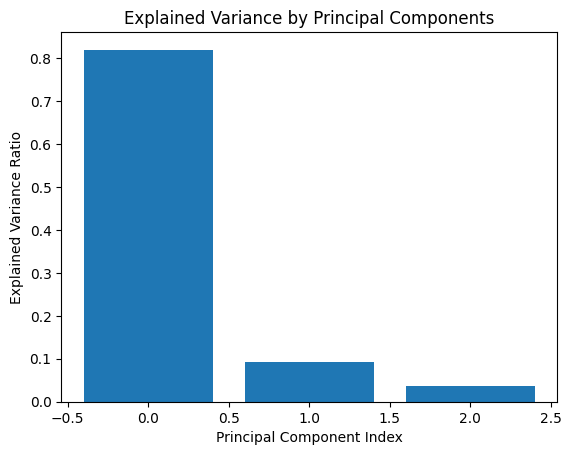

In [ ]:
# Step 5: Apply PCA
pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
plt.bar(range(len(explained_variance)), explained_variance)
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [ ]:
n_components = pca.n_components_
total_explained_variance = np.sum(explained_variance)
print(f"Number of PCA components to retain 95% variance: {n_components}")
print(f"Actual cumulative variance explained by retained components: {total_explained_variance:.4f}")


Number of PCA components to retain 95% variance: 3
Actual cumulative variance explained by retained components: 0.9507


In [ ]:

# Update X to use principal components
X = principal_components


# Create sequences
time_steps = 90
date_col = next((col for col in data.columns if "Date" in col), None)
if date_col:
    X_seq, y_seq, dates_seq = create_sequences(X, y_scaled, data[date_col].values, time_steps)
else:
    raise KeyError("Could not find a column containing 'Date'. Check available columns.")

# Train-test split
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X_seq, y_seq, dates_seq, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
model = Sequential([
    Input(shape=(time_steps, n_components)),  # Dynamically adjust input shape
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train
epochs = 10
batch_size = 25
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - loss: 0.0379 - val_loss: 0.0012
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 9.1287e-04 - val_loss: 0.0010
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 7.1626e-04 - val_loss: 0.0023
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - loss: 6.7816e-04 - val_loss: 0.0010
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 7.1326e-04 - val_loss: 0.0013
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 5.4579e-04 - val_loss: 0.0013
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 6.9681e-04 - val_loss: 0.0013
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 6.0972e-04 - val_loss: 0.0018


In [ ]:
# Step 8: Evaluating the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Mean Squared Error: 0.0017991381703488063


In [ ]:
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae_percentage = mean_absolute_percentage_error(y_test_actual, y_pred_actual)


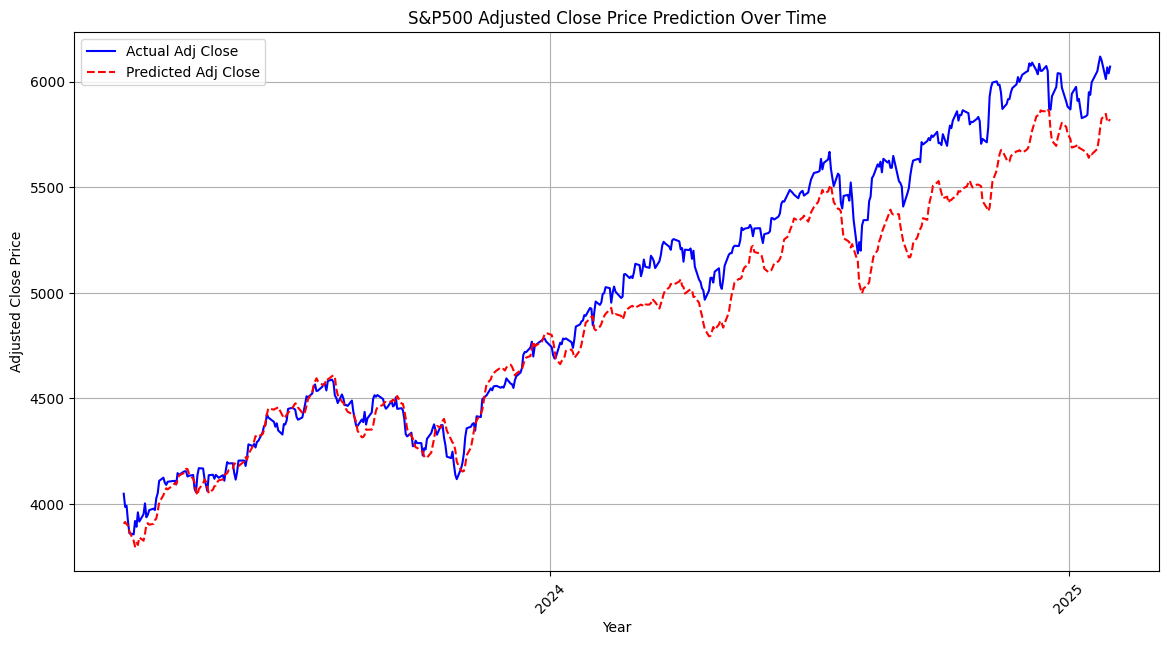

Mean Percentage Error: 0.026329500656699922
🔹 Root Mean Squared Error (RMSE): 0.0424


In [ ]:

plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test_actual, label="Actual Adj Close", color="blue")
plt.plot(dates_test, y_pred_actual, label="Predicted Adj Close", color="red", linestyle="dashed")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()

print(f"Mean Percentage Error: {mae_percentage}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")